# Coffee and Milk
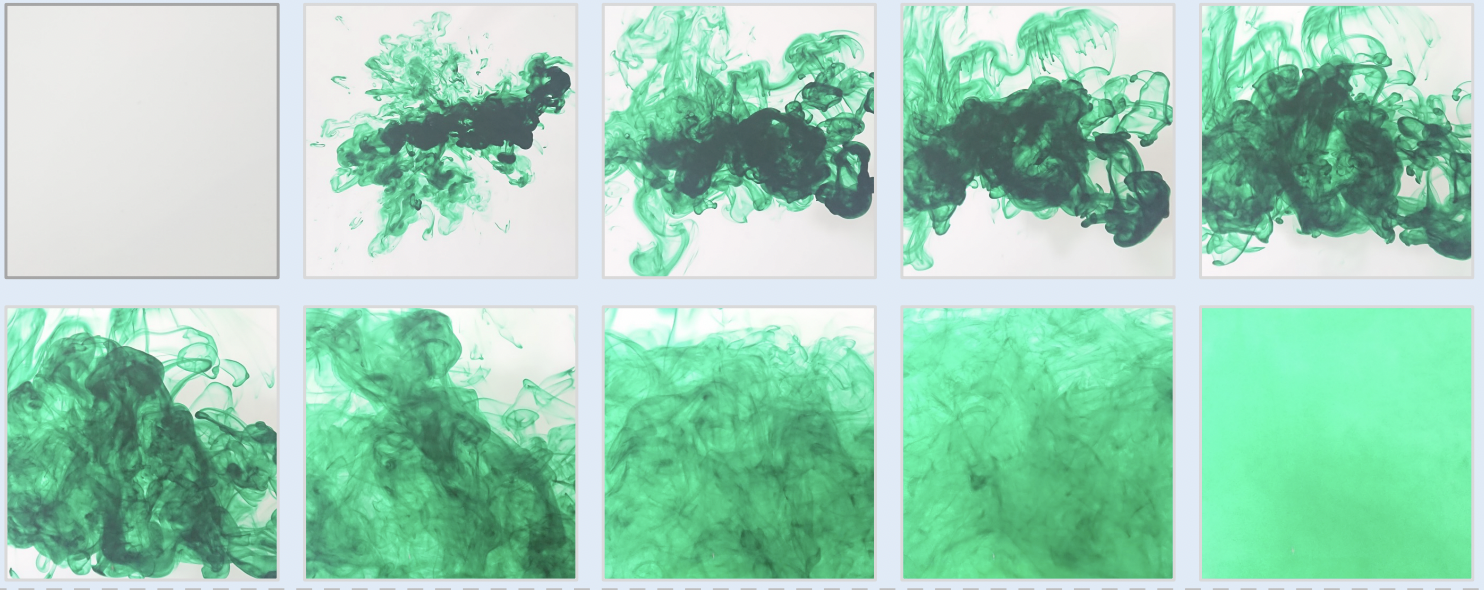

## Complexity and entropy of natural patterns
Haoyu Wang, Changqing Song, Peichao Gao

PNAS Nexus, Volume 3, Issue 10, October 2024
https://academic.oup.com/pnasnexus/article/3/10/pgae417/7761138

How can we evaluate complexity?

# The Ising Model

In [ ]:
lattice_size = 100
lattice <- matrix(sample(c(-1, 1), lattice_size^2, replace = TRUE),
                  nrow = lattice_size, ncol = lattice_size)

In [ ]:
image(lattice)

In [ ]:
J = 1
energy_change <- function(lattice, i, j) {
    neighbors_sum <- lattice[i, ifelse(j == ncol(lattice), 1, j + 1)] +
                     lattice[i, ifelse(j == 1, ncol(lattice), j - 1)] +
                     lattice[ifelse(i == 1, nrow(lattice), i - 1), j] +
                     lattice[ifelse(i == nrow(lattice), 1, i + 1), j]
    2 * J * lattice[i, j] * neighbors_sum
}

In [ ]:
temp = 2
beta <- 1.0 / temp

In [ ]:
    i <- sample(lattice_size, 1)
    j <- sample(lattice_size, 1)
    delta_E <- energy_change(lattice, i, j)
    if (delta_E < 0 || runif(1) < exp(-beta * delta_E)) {
      lattice[i, j] <- -lattice[i, j]
    }

In [ ]:
for (ii in 1:100000) {
    i <- sample(lattice_size, 1)
    j <- sample(lattice_size, 1)
    delta_E <- energy_change(lattice, i, j)
    if (delta_E < 0 || runif(1) < exp(-beta * delta_E)) {
      lattice[i, j] <- -lattice[i, j]
    }
}

In [ ]:
image(lattice)

Aside:
## The Algorithm of the Gods
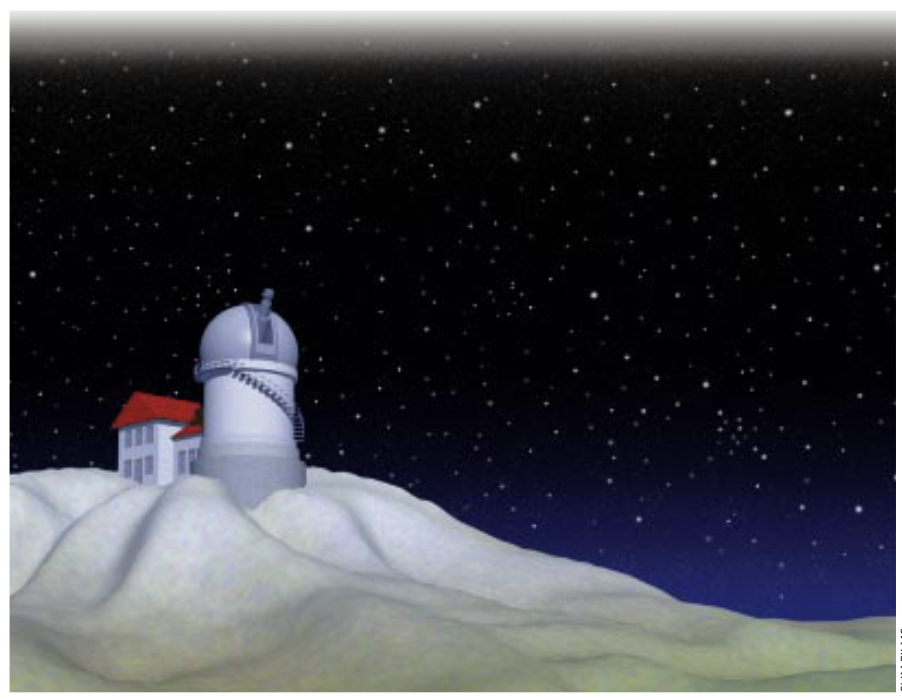
https://www.jstor.org/stable/24993668?seq=1

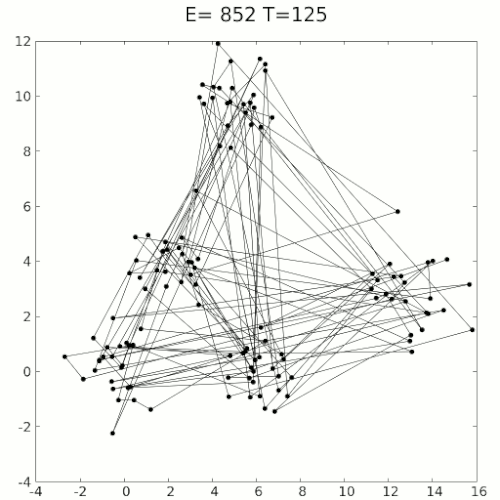
https://en.wikipedia.org/wiki/Simulated_annealing

Get size of a random segment

In [ ]:
indArray = function(rr, cc, dims) {
    (cc - 1) * dims[1] + rr
}

In [ ]:
checked = lattice * 0
tocheck = sample(lattice_size^2, 1)
value = lattice[arrayInd(tocheck, dim(lattice))]
total = 0

In [ ]:
while (length(tocheck) > 0) {
    index = tail(tocheck, 1)
    tocheck = tocheck[-length(tocheck)]  
    if (checked[index])
        next
    checked[index] = 1
    if (lattice[index] == value) {
        total = total + 1
        rc = arrayInd(index, dim(lattice))
        tocheck = c(tocheck, indArray(rc[1], ifelse(rc[2] == ncol(lattice), 1, rc[2] + 1), dim(lattice)),
                    indArray(rc[1], ifelse(rc[2] == 1, ncol(lattice), rc[2] - 1), dim(lattice)),
                    indArray(ifelse(rc[1] == 1, nrow(lattice), rc[1] - 1), rc[2], dim(lattice)),
                    indArray(ifelse(rc[1] == nrow(lattice), 1, rc[1] + 1), rc[2], dim(lattice)))
    }
}

In [ ]:
total

In [ ]:
get.all.sizes = function() {
    checked = lattice * 0
    totals = c()
    while (any(checked == 0)) {
        tocheck = which(checked == 0)[1]
        value = lattice[arrayInd(tocheck, dim(lattice))]
        total = 0
    
        while (length(tocheck) > 0) {
            index = tail(tocheck, 1)
            tocheck = tocheck[-length(tocheck)]  
            if (checked[index])
                next
            if (lattice[index] == value) {
                checked[index] = 1 # Only consider checked if included in this cluster
                total = total + 1
                rc = arrayInd(index, dim(lattice))
                tocheck = c(tocheck, indArray(rc[1], ifelse(rc[2] == ncol(lattice), 1, rc[2] + 1), dim(lattice)),
                            indArray(rc[1], ifelse(rc[2] == 1, ncol(lattice), rc[2] - 1), dim(lattice)),
                            indArray(ifelse(rc[1] == 1, nrow(lattice), rc[1] - 1), rc[2], dim(lattice)),
                            indArray(ifelse(rc[1] == nrow(lattice), 1, rc[1] + 1), rc[2], dim(lattice)))
            }
        }
    
        totals = c(totals, total)
    }
    totals
}

In [ ]:
get.ising = function(temp) {
    lattice_size = 50
    lattice <- matrix(sample(c(-1, 1), lattice_size^2, replace = TRUE),
                      nrow = lattice_size, ncol = lattice_size)
    
    beta <- 1.0 / temp
    
    for (ii in 1:100000) {
        i <- sample(lattice_size, 1)
        j <- sample(lattice_size, 1)
        delta_E <- energy_change(lattice, i, j)
        if (delta_E < 0 || runif(1) < exp(-beta * delta_E)) {
          lattice[i, j] <- -lattice[i, j]
        }
    }
    
    lattice
}

In [ ]:
lattice = get.ising(2)

In [ ]:
image(lattice)

In [ ]:
sizes = get.all.sizes()

Does this look like a power law?

In [ ]:
library(ggplot2)

In [ ]:
ggplot(data.frame(sizes), aes(sizes)) + geom_histogram() + scale_x_log10() + scale_y_log10()

Try entropy calculation

In [ ]:
get.all.entropy = function() {
    entropies = c()
    for (index in 1:length(lattice)) {
        rc = arrayInd(index, dim(lattice))
        neighbors = c(lattice[rc[1], ifelse(rc[2] == ncol(lattice), rc[2], rc[2] + 1)],
                      lattice[rc[1], ifelse(rc[2] == 1, ncol(lattice), rc[2] - 1)],
                      lattice[ifelse(rc[1] == 1, nrow(lattice), rc[1] - 1), rc[2]],
                      lattice[ifelse(rc[1] == nrow(lattice), 1, rc[1] + 1), rc[2]])
        entropy = -mean(neighbors == 1) * log2(mean(neighbors == 1)) -
            mean(neighbors == -1) * log2(mean(neighbors == -1))
        if (!is.finite(entropy))
            entropy = 0
        entropies = c(entropies, entropy)
    }
    entropies
}

Try range of temperatures

In [ ]:
outdf = data.frame()
for (temp in exp(seq(log(.1), log(10), length.out=20))) {
    print(temp)
    lattice = get.ising(temp)
    sizes = get.all.sizes()
    entropies = get.all.entropy()
    outdf = rbind(outdf, data.frame(temp, sizesd=sd(sizes), entropy=mean(entropies)))
}

In [ ]:
ggplot(outdf, aes(temp, entropy)) + geom_point() + scale_x_log10()

In [ ]:
ggplot(outdf, aes(temp, sizesd)) + geom_point() + scale_x_log10()

Hold left and right at opposite charges.

In [ ]:
J = 1
energy_change <- function(lattice, i, j) {
    neighbors_sum <- ifelse(j == ncol(lattice), 1, lattice[i, j + 1]) +
                     ifelse(j == 1, -1, lattice[i, j - 1]) +
                     ifelse(i == 1, 1, lattice[i - 1, j]) +
                     ifelse(i == nrow(lattice), -1, lattice[i + 1, j])
    2 * J * lattice[i, j] * neighbors_sum
}

In [ ]:
lattice_size = 50
lattice <- matrix(sample(c(-1, 1), lattice_size^2, replace = TRUE),
                  nrow = lattice_size, ncol = lattice_size)

In [ ]:
temp = 2
beta <- 1.0 / temp

In [ ]:
for (ii in 1:100000) {
    i <- sample(lattice_size, 1)
    j <- sample(lattice_size, 1)
    delta_E <- energy_change(lattice, i, j)
    if (delta_E < 0 || runif(1) < exp(-beta * delta_E)) {
      lattice[i, j] <- -lattice[i, j]
    }
}

In [ ]:
image(lattice)